In [1]:
import csv
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
sns.set_style("darkgrid")

# Lire la donnée

In [2]:
with open("iris.csv", "r") as f:
    iris = [row for row in csv.DictReader(f)]

# Transformer la donnée

In [3]:
Y_col = "class"
feature_names = [col for col in iris[0].keys() if col not in Y_col]
names = list(set(row[Y_col] for row in iris))

X = np.array([[float(row[feature]) for feature in feature_names] for row in iris])
y = np.array([names.index(row[Y_col]) for row in iris])

In [4]:
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is important for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2
)

n_features = X.shape[1]
n_classes = Y.shape[1]

# Visualisation

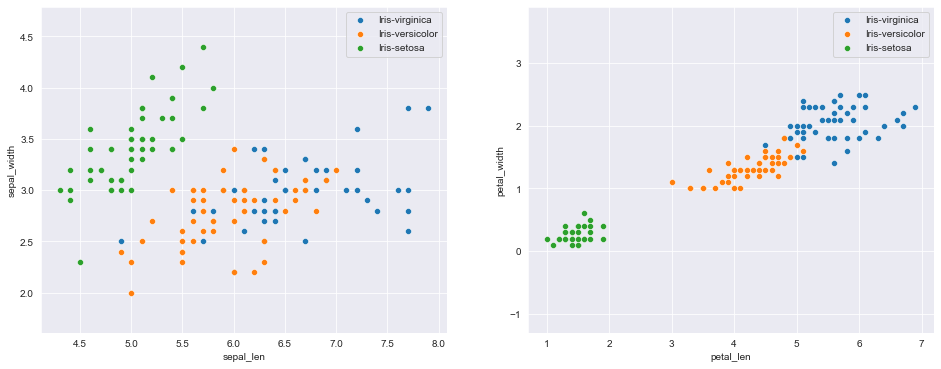

In [5]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    sns.scatterplot(X_plot[:, 0], X_plot[:, 1], marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    sns.scatterplot(X_plot[:, 2], X_plot[:, 3], marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

# Create models

In [6]:
def create_model(input_dim, output_dim, nodes, n=1, name='model'):
    model = Sequential(name=name)
    for i in range(n):
        model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

models = [create_model(n_features, n_classes, 8, i, f"model_{i}") for i in range(1,4)]

for model in models:
    model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 139
Trainable params: 139
Non-tr

# Train

In [7]:
history_dict = {}

cb = TensorBoard()

for model in models:
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print()
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.23906567692756653
Test accuracy: 0.9333333373069763

Model name: model_2
Test loss: 0.21340593695640564
Test accuracy: 0.9333333373069763

Model name: model_3
Test loss: 0.21688760817050934
Test accuracy: 0.9333333373069763



# Visualise results

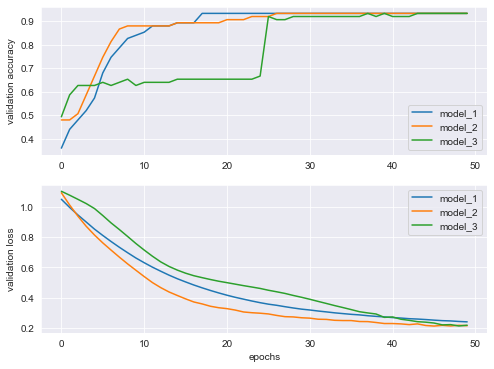

In [8]:
_, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

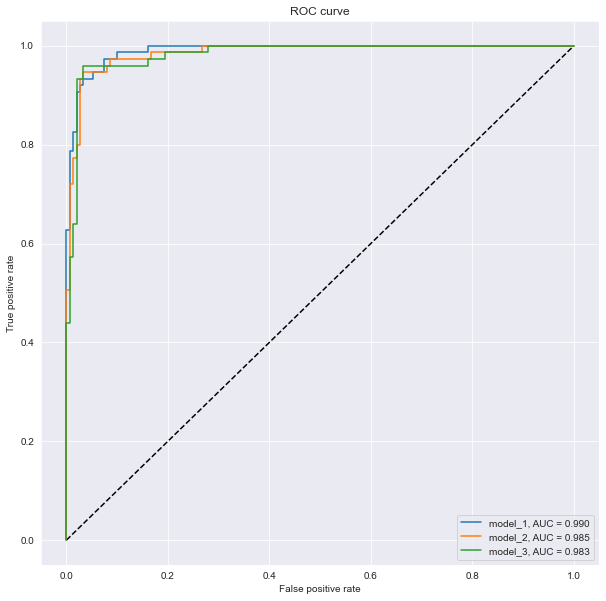

In [9]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();